Global Stiffness Matrix [[12488888.88888889        0.          1866666.66666667 -1244444.44444444
  -1244444.44444444 -1866666.66666667]
 [       0.          7466666.66666667  1866666.66666667 -1866666.66666667
   1866666.66666667  1866666.66666667]
 [ 1866666.66666667  1866666.66666667  3733333.33333333 -1866666.66666667
         0.                0.        ]
 [-1244444.44444444 -1866666.66666667 -1866666.66666667  1244444.44444444
         0.                0.        ]
 [-1244444.44444444  1866666.66666667        0.                0.
   1244444.44444444  1866666.66666667]
 [-1866666.66666667  1866666.66666667        0.                0.
   1866666.66666667  3733333.33333333]]
Force Matrix [-20000.              0.              0.            778.21011673
   1712.06225681   2801.55642023]
Displacement Matrix [-0.00175097 -0.00025014  0.00100056  0.          0.          0.        ]
Force in spring -8754.863813229571
Reaction at node 4: 8754.863813229571


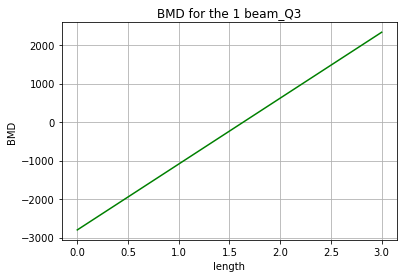

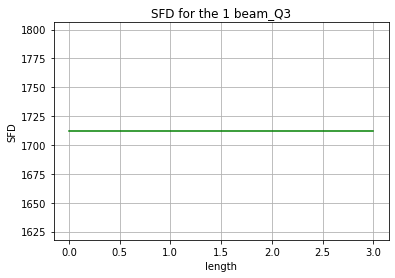

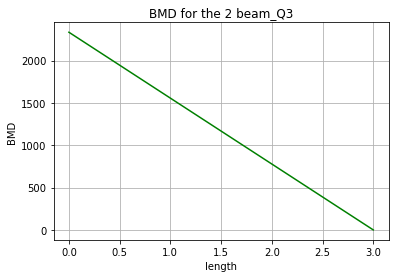

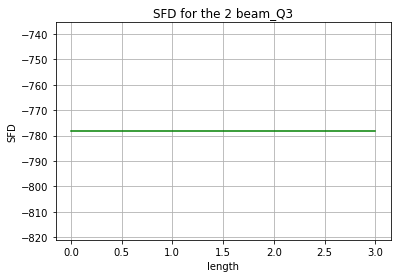

Member Displacement [[ 0.         -0.00175097]
 [ 0.         -0.00025014]
 [-0.00175097  0.        ]
 [-0.00025014  0.00100056]]
Member Forces [[ 1712.06225681  -778.21011673]
 [ 2801.55642023 -2334.63035019]
 [-1712.06225681   778.21011673]
 [ 2334.63035019     0.        ]]


In [12]:
import math
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
nbeam=2
nnodes=3
dofpernode=2
totaldof=nnodes*dofpernode
k_spring=5000000 #change variable k_spring to change k vale
#all the free dof should be numbered first and then the constrained ones.
# all units are SI units
#boundary matrix content boundary conditions of the beam 0 if dof is free and 1 if dof is constrained
#element matrix contain material and geometric properties 1st column length,2nd Young's Modulus and 3rd moment of interia
Force = np.loadtxt("C:\\Users\\hp\\Downloads\\2021CES2770_A2\\2021CES2770_A2_Q3\\force.txt", dtype=float)
Displacement = np.loadtxt("C:\\Users\\hp\\Downloads\\2021CES2770_A2\\2021CES2770_A2_Q3\\displacement.txt", dtype=float)
association_mat=np.loadtxt("C:\\Users\\hp\\Downloads\\2021CES2770_A2\\2021CES2770_A2_Q3\\association.txt", dtype=int)
element=np.loadtxt("C:\\Users\\hp\\Downloads\\2021CES2770_A2\\2021CES2770_A2_Q3\\element.txt", dtype=float)
boundary=np.loadtxt("C:\\Users\\hp\\Downloads\\2021CES2770_A2\\2021CES2770_A2_Q3\\boundary.txt", dtype=int)
Force=np.transpose(Force)
Displacement=np.transpose(Displacement)
KTS=np.zeros((totaldof,totaldof))
markerd=np.zeros(0)
markerf=np.zeros(0)
P=np.zeros(0)
Ux=np.zeros(0)
count=0
for m in range(totaldof):
        if boundary[m]==0:
            P=np.append(P,[Force[m]],axis=0) 
            markerf=np.append(markerf,m)
            count=count+1
        else:
            Ux=np.append(Ux,[Displacement[m]],axis=0)
            markerd=np.append(markerd,m)   
P=np.transpose(P)
Ux=np.transpose(Ux)

nfree=count
nrestrained=totaldof-count  
Ke=np.zeros(((4,4,nbeam)))
for i in range(0,nbeam):
    l=element[i,0]
    E=element[i,1]
    I=element[i,2]
    a=12*E*I/(l**3)
    b=6*E*I/(l**2)
    c=4*E*I/l
    d=2*E*I/l
    Ke[:,:,i]=np.array([(a,b,-a,b),(b , c , -b ,d),(-a, -b, a, -b),(b, d, -b, c)])
    expanded_element_stiffness=np.zeros((totaldof,totaldof))
    for j in range(2*dofpernode):
        for k in range (2*dofpernode):
            expanded_element_stiffness[association_mat[i,j]-1,association_mat[i,k]-1]=Ke[j,k,i]                
    KTS=KTS+expanded_element_stiffness
    KTS[0,0]=KTS[0,0]+k_spring
print('Global Stiffness Matrix',KTS)
Kpp=KTS[0:nfree,0:nfree]
Kpx=KTS[0:nfree,nfree:totaldof]
Kxp=np.transpose(Kpx)
Kxx=KTS[nfree:totaldof,nfree:totaldof]

Kpp_inverse=np.linalg.inv(Kpp)
Up=Kpp_inverse@P-Kpp_inverse@Kpx@Ux
X=Kxp@Up+Kxx@Ux

Displacement=np.concatenate((Up, Ux), axis=0)
Force=np.concatenate((P, X), axis=0)
print('Force Matrix',Force)
print('Displacement Matrix',Displacement)

u=np.zeros((2*dofpernode,nbeam)) 
f=np.zeros((2*dofpernode,nbeam))
Spring_Force=5000000*Displacement[0]
print('Force in spring',Spring_Force)
#Reaction_4=-1*Spring_force
print('Reaction at node 4:',-1*Spring_Force)
for i in range(0,nbeam):
    for j in range(0,2*dofpernode):
        u[j,i]=Displacement[association_mat[i,j]-1]
    f[:,i]=Ke[:,:,i]@u[:,i]
    l=element[i,0]
    E=element[i,1]
    I=element[i,2]
    a=((2*(u[0,i]-u[2,i])/(l**3))+(u[1,i]+u[3,i])/(l**2))*E*I
    b=((-3*(u[0,i]-u[2,i])/l**2)-(2*u[1,i]+u[3,i])/l)*E*I
    c=6*a
    d=2*b
    x = np.linspace(0, l,100)
    y =  (c * x) + d
    plt.plot(x, y, '-g', label=r'BMD')
    plt.xlabel('length')
    plt.ylabel('BMD')
    plt.title("BMD for the %i beam_Q3"%(i+1))
    plt.grid(True)
    plt.show()
    x = np.linspace(0, l,100)
    y =  c+0*x
    plt.plot(x, y, '-g', label=r'SFD')
    plt.xlabel('length')
    plt.ylabel('SFD')
    plt.title("SFD for the %i beam_Q3"%(i+1))
    plt.grid(True)
    plt.show()
print('Member Displacement',u)
print('Member Forces',f)